In [494]:
from sklearn import model_selection
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pylab import *
%matplotlib inline 
%config InlineBackend.figure_format="retina" 

In [495]:
# 画决策树

import matplotlib.pyplot as plt
from pylab import *
 
# 定义文本框和箭头格式
decisionNode = dict(boxstyle="sawtooth", fc="0.8")
leafNode = dict(boxstyle="round4", fc="0.8")
arrow_args = dict(arrowstyle="<-")
mpl.rcParams['font.sans-serif'] = ['SimHei'] #指定默认字体
mpl.rcParams['axes.unicode_minus'] = False #解决保存图像是负号'-'显示为方块的问题
 
def plotMidText(cntrPt, parentPt, txtString):
    xMid = (parentPt[0]-cntrPt[0])/2.0 + cntrPt[0]
    yMid = (parentPt[1]-cntrPt[1])/2.0 + cntrPt[1]
    createPlot.ax1.text(xMid, yMid, txtString)

def plotNode(nodeTxt, centerPt, parentPt, nodeType): # 绘制带箭头的注解
    createPlot.ax1.annotate(nodeTxt, xy=parentPt, xycoords="axes fraction", xytext=centerPt, textcoords="axes fraction", va="center", ha="center", bbox=nodeType, arrowprops=arrow_args)

def getNumLeafs(myTree): # 获取叶节点的数目
    numLeafs = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    if type(secondDict).__name__ == 'dict':
        for key in secondDict.keys():
            if type(secondDict[key]).__name__ == 'dict':
                numLeafs += getNumLeafs(secondDict[key])
            else: numLeafs += 1
    else:
        numLeafs += 1
    return numLeafs
 
def getTreeDepth(myTree): # 获取树的层数
    maxDepth = 0
    firstStr = list(myTree.keys())[0]
    secondDict = myTree[firstStr]
    if type(secondDict).__name__ == 'dict':
        for key in secondDict.keys():
            if type(secondDict[key]).__name__ == 'dict':
                thisDepth = 1 + getTreeDepth(secondDict[key])
            else: 
                thisDepth = 1
            if thisDepth > maxDepth: 
                maxDepth = thisDepth
    else:
        maxDepth = 1
    return maxDepth
 
def retrieveTree(i): # 获取预定义的树
    listOfTrees =[{'no surfacing': {0: 'no', 1: {'flippers': {0: 'no', 1: 'yes'}}}},
                  {'no surfacing': {0: 'no', 1: {'flippers': {0: {'head': {0: 'no', 1: 'yes'}}, 1: 'no'}}}}
                  ]
    return listOfTrees[i]
 
def plotTree(myTree, parentPt, nodeTxt):
    numLeafs = getNumLeafs(myTree)
    getTreeDepth(myTree)
    firstStr = list(myTree.keys())[0]
    cntrPt = (plotTree.xOff + (1.0 + float(numLeafs))/2.0/plotTree.totalW,\
    plotTree.yOff)
    plotMidText(cntrPt, parentPt, nodeTxt)
    plotNode(firstStr, cntrPt, parentPt, decisionNode)
    secondDict = myTree[firstStr]
    plotTree.yOff = plotTree.yOff - 1.0/plotTree.totalD
    if type(secondDict).__name__=='dict':
        for key in secondDict.keys():
            if type(secondDict[key]).__name__=='dict':
                plotTree(secondDict[key],cntrPt,str(key))
            else:
                plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
                plotNode(secondDict[key], (plotTree.xOff, plotTree.yOff),
                cntrPt, leafNode)
                plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(key))
    else:
        plotTree.xOff = plotTree.xOff + 1.0/plotTree.totalW
        plotNode(secondDict, (plotTree.xOff, plotTree.yOff),cntrPt, leafNode)
        plotMidText((plotTree.xOff, plotTree.yOff), cntrPt, str(secondDict))
    plotTree.yOff = plotTree.yOff + 1.0/plotTree.totalD

    
def createPlot(inTree):
    fig = plt.figure(1, figsize=(12, 8), facecolor='white')
    fig.clf()
    axprops = dict(xticks=[], yticks=[])
    createPlot.ax1 = plt.subplot(111, frameon=False, **axprops)
    plotTree.totalW = float(getNumLeafs(inTree))
    plotTree.totalD = float(getTreeDepth(inTree))
    plotTree.xOff = -0.5/plotTree.totalW; plotTree.yOff = 1.0;
    plotTree(inTree, (0.5,1.0), '')
    plt.show()

In [496]:
# 判断当前数据集中是否类别全部相同
def same_category(D):
    num = D.loc[:,'好瓜'].nunique()
    if num == 1:
        flag = True
    else:
        flag = False
    return flag, D.iloc[0,-1]
    
# 判断当前属性集是否为空
def empty_attribute(A):
    num=A.nunique()
    if num==0:
        return True
    else:
        return False

# 判断当前数据集在属性集A上取值是否相同
def sameOnA(D,A):
    num = D.loc[:,A].nunique()
    num=np.sum(num)
    numA = len(A)
    if num == numA:
        return True
    else:
        return False

# 找出数据集D中样本数最多的类别
def findMost(D):
    good=D.loc[D['好瓜']==1,:].shape[0]
    bad=D.loc[D['好瓜']==0,:].shape[0]
    if good>=bad:
        return '好瓜'
    else:
        return '坏瓜'

# 使用基尼指数
def Gini(D):
    num=D.shape[0]
    curGini=1
    cate=[1,0]
    for c in cate:
        c_num=D.loc[D['好瓜']==c,:].shape[0]
        if c_num==0:
            tmp=0
        else:
            pk=c_num/num
            tmp=pk*pk    
        curGini-=tmp
    return curGini

#在D中找出取值为a的子集
def getDv_a(D,A,a):
    Dv_a=D.loc[D[A]==a,:]
    return Dv_a

# 基于Gini指数找出当前最优属性
def findBestA(D,A):
    selectA=''
    Gmin=100000
    for a in A:
        Gini_index=0
        D_num=D.shape[0]
        for av in pd.unique(D.loc[:, a]):
            Dv_a=getDv_a(D,a,av)
            a_num=Dv_a.shape[0]
            Gini_index+=a_num *Gini(Dv_a)/D_num
        
        
        if Gini_index<Gmin:
            Gmin=Gini_index
            selectA=a

    return selectA

In [497]:
def ReadData(pathname):
    data=pd.read_csv(pathname)
    data.loc[data['好瓜']=='是', '好瓜'] = 1
    data.loc[data['好瓜']=='否', '好瓜'] = 0
    data = data.iloc[:,1:]
    
    trainIndex = [0, 1, 2, 3,5, 6, 9, 13, 14, 15, 16]
    testIndex = [4,7,8,10,11,12]
    traindata = []
    testdata = []

    traindata=data.loc[trainIndex,:]
    testdata=data.loc[testIndex,:]
    
    return traindata,testdata

In [498]:
def treeGenerate(D,A,root,lastNode,lastA):
    flag, category = same_category(D)
    if flag:
        if category==1:
            lastNode[lastA] = '好瓜'  
        else:
            lastNode[lastA] = '坏瓜'
        return
    
    if empty_attribute(A) or sameOnA(D,A):
        lastNode[lastA]=findMost(D)
        return
    
    best_a=findBestA(D,A)

    root[best_a]={}
    for av in pd.unique(data.loc[:,best_a]):
        Dv = getDv_a(D,best_a,av)
        if Dv.shape[0]==0:
            root[best_a][av]=findMost(D)
        else:
            A_ = A.drop(best_a)
            root[best_a][av] = {}
            lastA = av
            
            treeGenerate(Dv,A_,root[best_a][av],root[best_a],lastA)
    

In [507]:
def calAccNum(D,Dtest):
    nodeClass=findMost(D)

    if nodeClass=='好瓜':
        nodeClass=1
    else:
        nodeClass=0

    cnt=Dtest.loc[Dtest['好瓜']==nodeClass,:].shape[0]
    return cnt

def cmpAcc(D,Dtest,basAcc,a,axis):
    nowAcc=0

    for av in pd.unique(Dtest.loc[:,a]):
        Dv=getDv_a(D,a,av)
        Dv_test=getDv_a(Dtest,a,av)
        nowAcc+=calAccNum(Dv,Dv_test)
    
    # 用于表示预剪枝比较
    if axis==1:
        if nowAcc>basAcc:
            return True
        else:
            return False
    else:# 用于表示后剪枝比较
        if nowAcc>=basAcc:
            return True
        else:
            return False
     

In [508]:
# 预剪枝
def prePruning(D,Dtest,A,root,lastNode,lastA):
    # 如果基尼指数为0，即D中样本全属于同一类别，返回
    flag, category = same_category(D)
    if flag:
        if category==1:
            lastNode[lastA] = '好瓜'  
        else:
            lastNode[lastA] = '坏瓜'
        return
    
    if empty_attribute(A) or sameOnA(D,A):
        lastNode[lastA]=findMost(D)
        return
    best_a=findBestA(D,A)
    
    accCnt=calAccNum(D,Dtest)
    
    # 如果不划分的正确率更高，则不划分
    if cmpAcc(D,Dtest,accCnt,best_a,1):
        root[best_a]={}
    else:
        lastNode[lastA]=findMost(D)
        return
    
    for av in pd.unique(data.loc[:,best_a]):

        Dv = getDv_a(D,best_a,av)
        
        Dv_test=getDv_a(Dtest,best_a,av)
        
        if Dv.shape[0]==0:
            root[best_a][av]=findMost(D)
        else:
            A_ = A.drop(best_a)
            root[best_a][av] = {}
            lastA = av
            
            prePruning(Dv,Dv_test,A_,root[best_a][av],root[best_a],lastA)
    

In [509]:
# 后剪枝
def postPruning(D,Dtest,A,root,lastNode,lastA):
    
    flag, category = same_category(D)
    if flag:
        if category==1:
            lastNode[lastA] = '好瓜'  
        else:
            lastNode[lastA] = '坏瓜'
        return
    
    if empty_attribute(A) or sameOnA(D,A):
        lastNode[lastA]=findMost(D)
        return
    
    best_a=findBestA(D,A)
    if lastA!=None:
        lastlastA=lastA
    else:
        lastlastA=None
        
    root[best_a]={}
    for av in pd.unique(data.loc[:,best_a]):
        Dv = getDv_a(D,best_a,av)
        Dv_test=getDv_a(Dtest,best_a,av)
        if Dv.shape[0]==0:
            root[best_a][av]=findMost(D)
        else:
            A_ = A.drop(best_a)
            root[best_a][av] = {}
            lastA = av

            postPruning(Dv,Dv_test,A_,root[best_a][av],root[best_a],lastA)
    

    # 针对叶子结点开始剪枝
    
    accCnt=calAccNum(D,Dtest)# 计算剪枝的正确率

    # 如果不划分的正确率更高，则不划分
    if cmpAcc(D,Dtest,accCnt,best_a,0)==False:
        #lastNode[lastA]=findMost(D)
        lastNode[lastlastA]=findMost(D)

        return



未剪枝 {'脐部': {'凹陷': {'色泽': {'青绿': '好瓜', '乌黑': '好瓜', '浅白': '坏瓜'}}, '稍凹': {'根蒂': {'蜷缩': '坏瓜', '稍蜷': {'色泽': {'青绿': '好瓜', '乌黑': {'纹理': {'清晰': '坏瓜', '稍糊': '好瓜', '模糊': '好瓜'}}, '浅白': '好瓜'}}, '硬挺': '好瓜'}}, '平坦': '坏瓜'}}


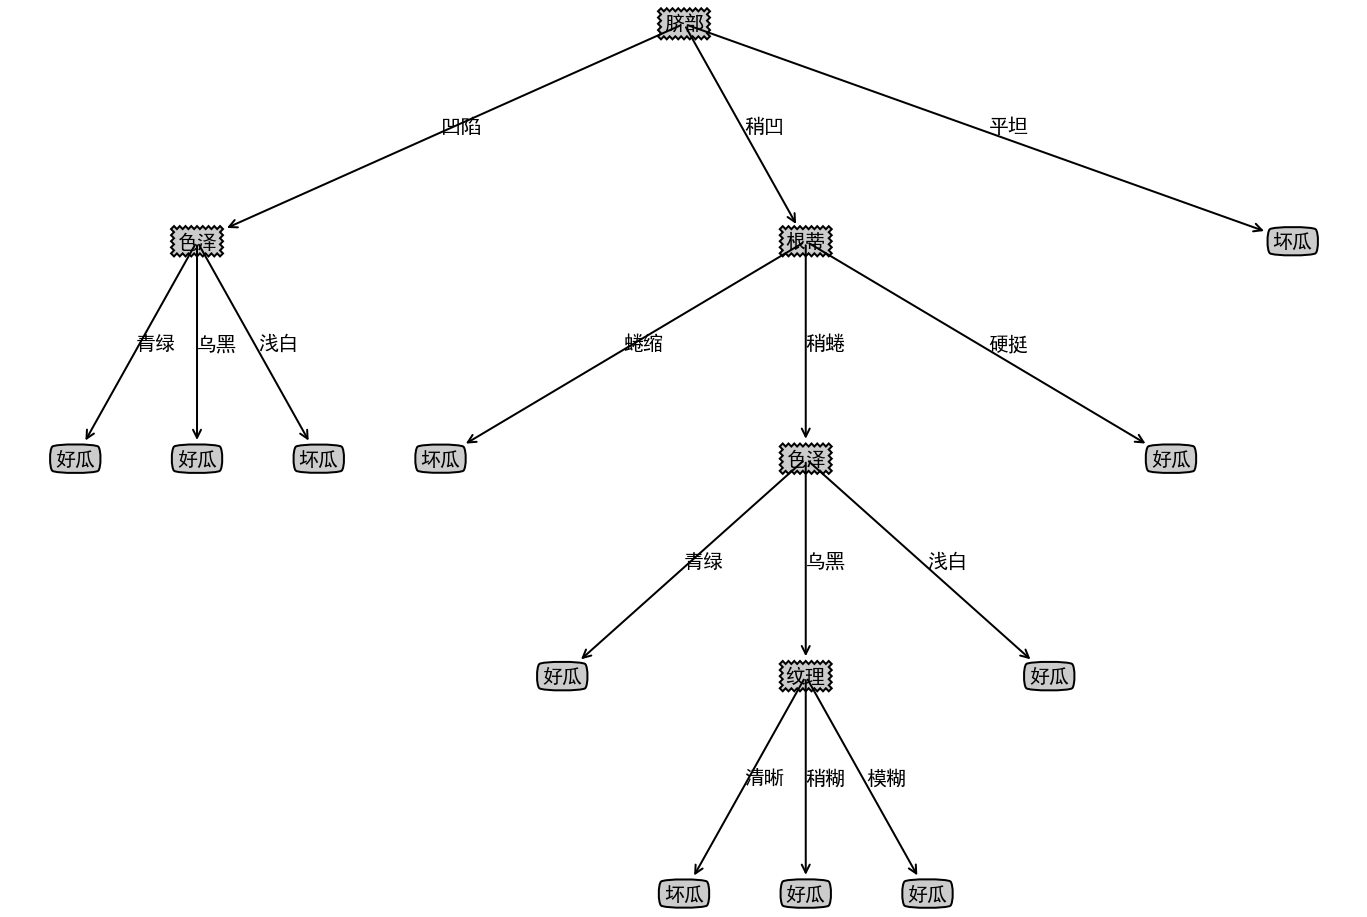

预剪枝 {'脐部': {'凹陷': '好瓜', '稍凹': '好瓜', '平坦': '坏瓜'}}


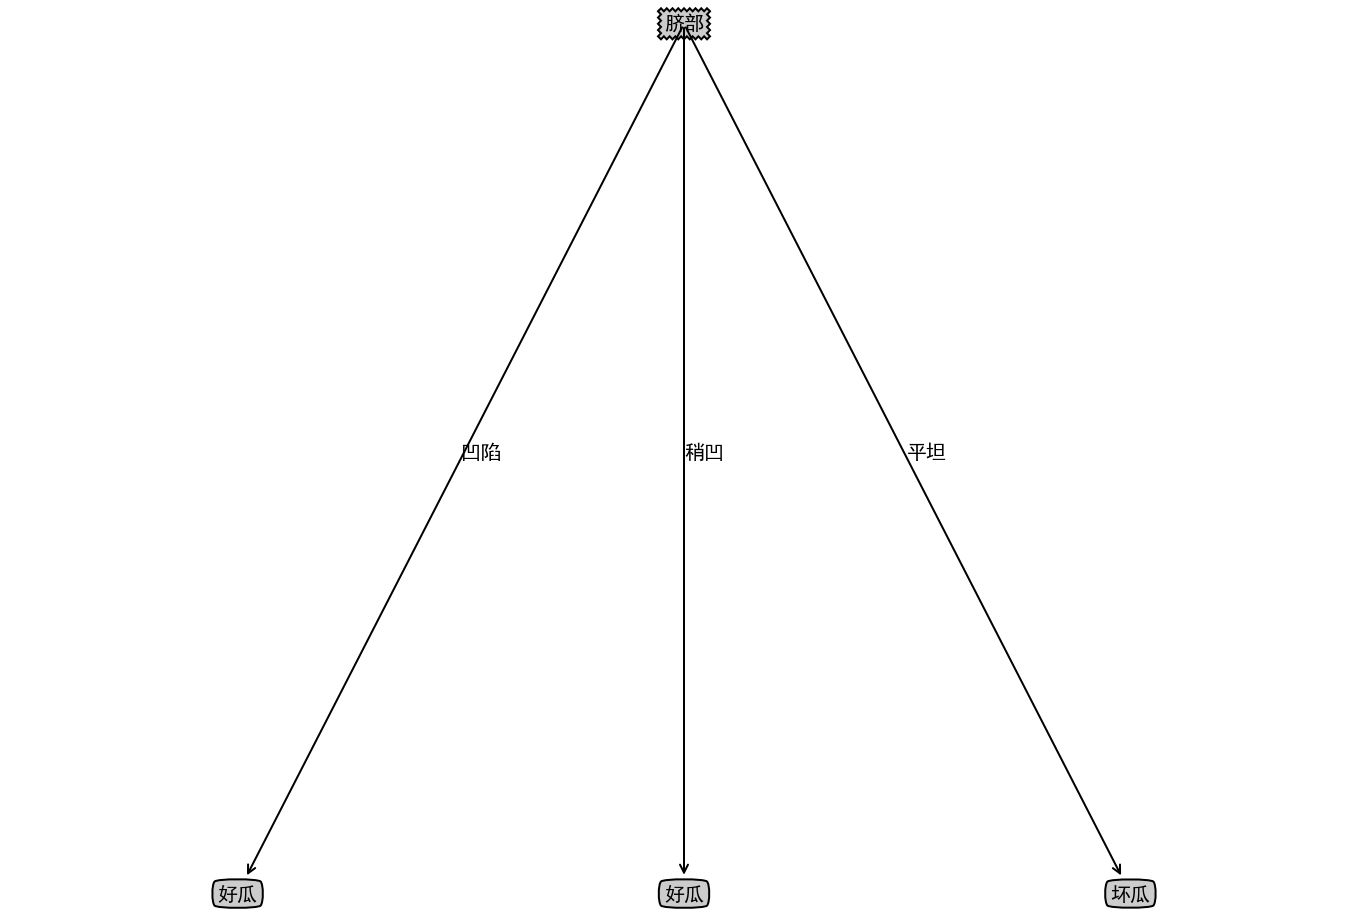

后剪枝 {'脐部': {'凹陷': '好瓜', '稍凹': {'根蒂': {'蜷缩': '坏瓜', '稍蜷': {'色泽': {'青绿': '好瓜', '乌黑': '好瓜', '浅白': '好瓜'}}, '硬挺': '好瓜'}}, '平坦': '坏瓜'}}


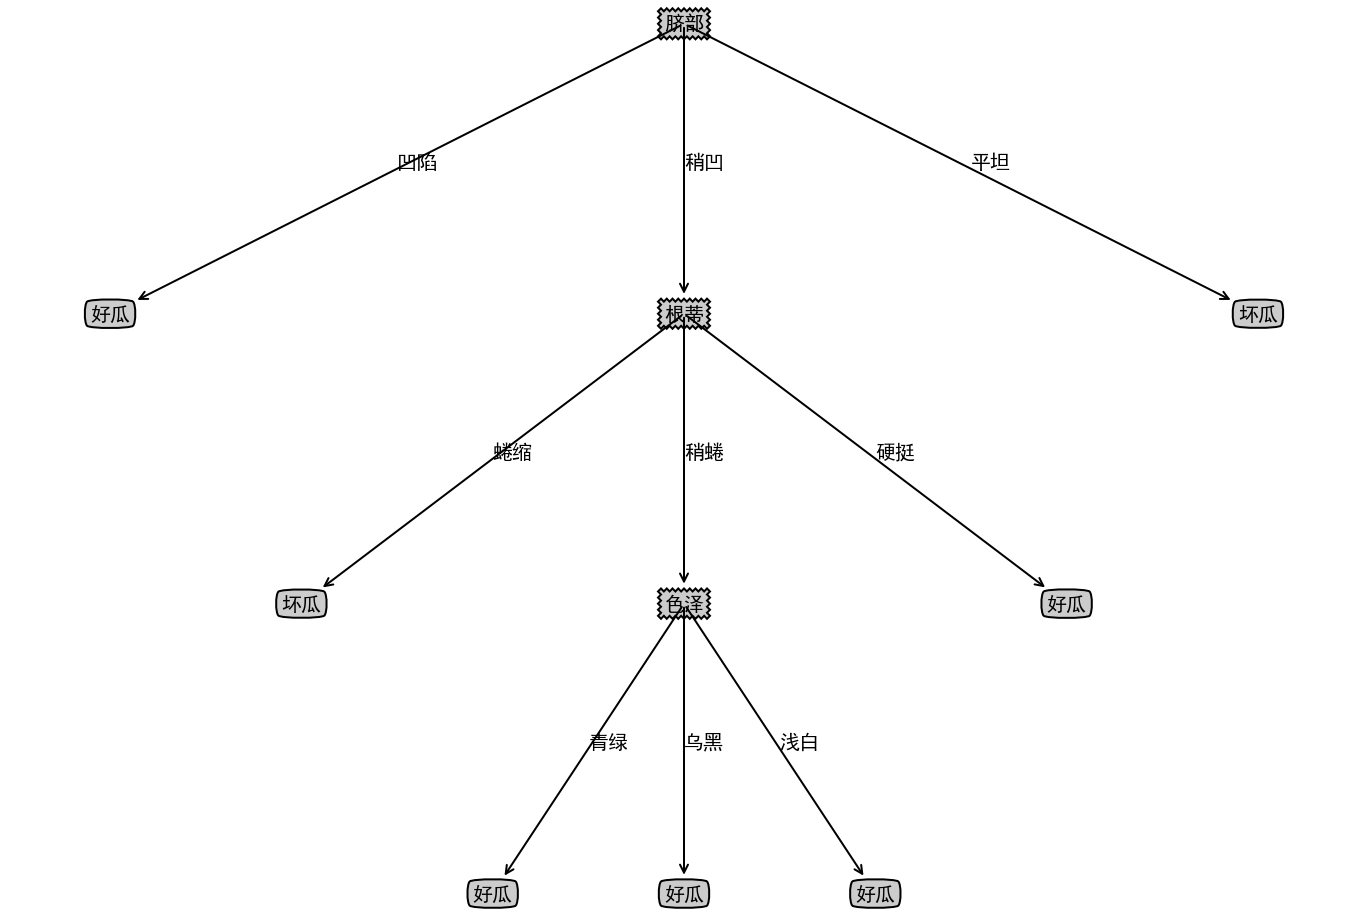

In [510]:
if __name__ == '__main__':
    traindata,testdata=ReadData('./watermelon_2.csv')

    root={}
    attribute=data.columns[:-1]
    
    lastNode=None
    lastA=None
    
    treeGenerate(traindata,attribute,root,lastNode,lastA)
    print("未剪枝",root)
    createPlot(root)
    
    
    root={}
    prePruning(traindata,testdata,attribute,root,lastNode,lastA)
    print("预剪枝",root)
    createPlot(root)
    
    root={}
    postPruning(traindata,testdata,attribute,root,lastNode,lastA)
    print("后剪枝",root)
    createPlot(root)
    